### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import os, time, random

import tensorflow as tf
from PIL import Image
from skimage import io

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#########################
# DL Libraries
#########################
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomZoom, Rescaling
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from keras import backend as K

In [2]:
## set seed for producing same results
# seed = 2020
# np.random.seed(seed)
# tf.random.set_seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

### Check Available Data

In [3]:
dir_path='../input/chest-xray-pneumonia/chest_xray/'

train_path = dir_path+'train/'
valid_path = dir_path+'val/'
test_path = dir_path+'test/'

In [4]:
### check number of train, valid and test images 
labels = ['NORMAL', 'PNEUMONIA']

def check_ims_in_folder(labels):
    '''returns tuples of images in each folder'''
    train_ims_normal = os.listdir(train_path+labels[0]+'/')
    train_ims_pneumonia = os.listdir(train_path+labels[1]+'/')
    
    valid_ims_normal = os.listdir(valid_path+labels[0]+'/')
    valid_ims_pneumonia = os.listdir(valid_path+labels[1]+'/')
    
    test_ims_normal = os.listdir(test_path+labels[0]+'/')
    test_ims_pneumonia = os.listdir(test_path+labels[1]+'/')
    
    return (train_ims_normal, train_ims_pneumonia), (valid_ims_normal, valid_ims_pneumonia), (test_ims_normal, test_ims_pneumonia)

### Check Label Distribution (Each Folder)

[0.15 1.15 2.15 3.15 4.15 5.15]


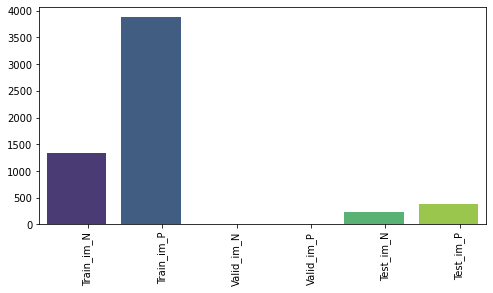

train_im_N:  1341
train_im_P:  3875
valid_im_N:  8
valid_im_P:  8
test_im_N:  234
test_im_P:  390


In [5]:
(train_im_n, train_im_p), (valid_im_n, valid_im_p), (test_im_n, test_im_p) = check_ims_in_folder(labels)


index = np.arange(6) + 0.15
print (index)
labels_bar = ['Train_im_N', 'Train_im_P', 'Valid_im_N', 'Valid_im_P', 'Test_im_N', 'Test_im_P']

fig=plt.figure(figsize=(8, 4))
sns.barplot(x=index, y=[len(train_im_n), len(train_im_p), len(valid_im_n), len(valid_im_p), len(test_im_n), len(test_im_p)], palette="viridis")
plt.xticks(index, labels_bar, rotation='vertical')
plt.show()

print ('train_im_N: ', len(train_im_n))
print ('train_im_P: ', len(train_im_p))
print ('valid_im_N: ', len(valid_im_n))
print ('valid_im_P: ', len(valid_im_p))
print ('test_im_N: ', len(test_im_n))
print ('test_im_P: ', len(test_im_p))

**Number of Validation Images are too less**. 

To deal with that we will later combine train and validation folders and then do a split. 

I have TensorFlow Dataset structure. 

### Class Imbalance Data (Positive Samples >> Negative Samples)

In [6]:
tot_normal_train = len(train_im_n) + len(valid_im_n) 
tot_pneumonia_train = len(train_im_p) + len(valid_im_p)
print ('total normal xray images: ', tot_normal_train)
print ('total pneumonia xray images: ', tot_pneumonia_train)

total normal xray images:  1349
total pneumonia xray images:  3883


## Inference from 1st training 
1. Low number of files in validation data forlder (only 16), is useless to to validate this model. We add training and test data and then do a 15% split to create validation data. 



So the training data is imbalanced and we have more positive samples

### Check Image Size Disrtibution (Each Folder)

In [7]:
def check_im_size(folder, labels):
    im_shape_x_lists_n = []
    im_shape_x_lists_p = []
    im_shape_y_lists_n = []
    im_shape_y_lists_p = []
    if folder=='val':
        path = valid_path
        normal = valid_im_n
        pneumonia = valid_im_p
    elif folder=='train':
        path = train_path
        normal = train_im_n
        pneumonia = train_im_p
    else:
        path = test_path
        normal = test_im_n
        pneumonia = test_im_p
    for i, img in enumerate(normal):
        sample = os.path.join(path+labels[0]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_n.append(w)
        im_shape_y_lists_n.append(h)
    for i, img in enumerate(pneumonia):
        sample = os.path.join(path+labels[1]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_p.append(w)
        im_shape_y_lists_p.append(h)
        
    return im_shape_x_lists_n, im_shape_y_lists_n, im_shape_x_lists_p, im_shape_y_lists_p

In [8]:
im_shape_valid_x_n, im_shape_valid_y_n, im_shape_valid_x_p, im_shape_valid_y_p = check_im_size('val', labels)
im_shape_train_x_n, im_shape_train_y_n, im_shape_train_x_p, im_shape_train_y_p = check_im_size('train', labels)
im_shape_test_x_n, im_shape_test_y_n, im_shape_test_x_p, im_shape_test_y_p = check_im_size('test', labels)  

{1632, 1736, 1288, 1776, 1328, 1272, 1564, 1240} {928, 1416, 1225, 1040, 1104, 1302}


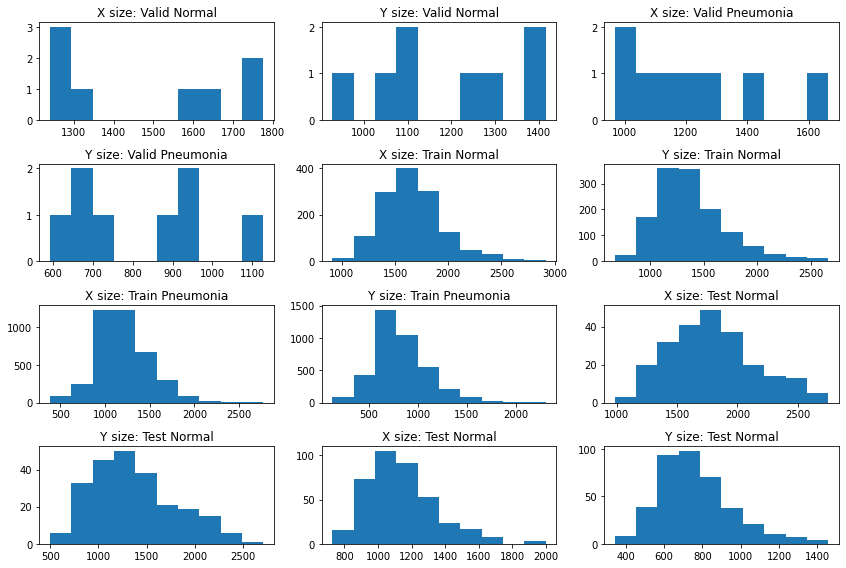

In [9]:
fig = plt.figure(figsize=(12, 8))

fig.add_subplot(431)
plt.hist(im_shape_valid_x_n)
plt.title('X size: Valid Normal')
fig.add_subplot(432)
plt.hist(im_shape_valid_y_n)
plt.title('Y size: Valid Normal')
fig.add_subplot(433)
plt.hist(im_shape_valid_x_p)
plt.title('X size: Valid Pneumonia')
fig.add_subplot(434)
plt.hist(im_shape_valid_y_p)
plt.title('Y size: Valid Pneumonia')
fig.add_subplot(435)
plt.hist(im_shape_train_x_n)
plt.title('X size: Train Normal')
fig.add_subplot(436)
plt.hist(im_shape_train_y_n)
plt.title('Y size: Train Normal')
fig.add_subplot(437)
plt.hist(im_shape_train_x_p)
plt.title('X size: Train Pneumonia')
fig.add_subplot(438)
plt.hist(im_shape_train_y_p)
plt.title('Y size: Train Pneumonia')
fig.add_subplot(439)
plt.hist(im_shape_test_x_n)
plt.title('X size: Test Normal')
fig.add_subplot(4,3, 10)
plt.hist(im_shape_test_y_n)
plt.title('Y size: Test Normal')
fig.add_subplot(4,3, 11)
plt.hist(im_shape_test_x_p)
plt.title('X size: Test Normal')
fig.add_subplot(4,3, 12)
plt.hist(im_shape_test_y_p)
plt.title('Y size: Test Normal')
plt.tight_layout()
print (set(im_shape_valid_x_n), set(im_shape_valid_y_n))

**The sizes of the images vary over a wide range. So best option is to fix a size for all.** 

**Since we are using InceptionResNet, the input size we will consider is 300x300.** 

### Check Some Images 

Pneumonia and Normal (from training directory)

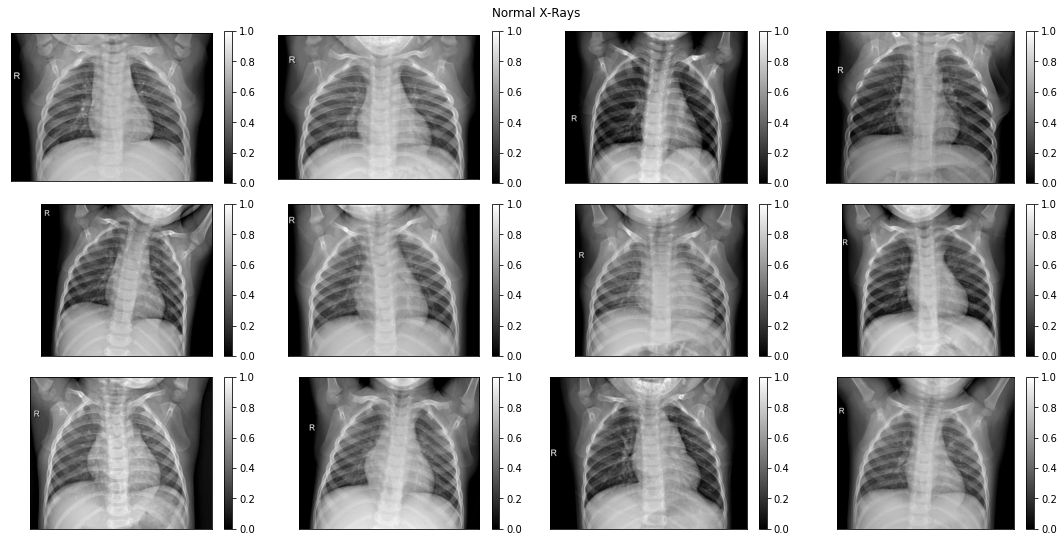

check shape of an example image:  (1612, 1870)


In [10]:
fig = plt.figure(figsize=(15, 10))
npics= 12

count = 1
train_im_n_selected = random.sample(train_im_n, 12)
for i, img in enumerate(train_im_n_selected):
    sample = os.path.join(train_path +labels[0]+'/', img) 
    sample_img = Image.open(sample)   
    sample_img = np.array(sample_img)
    sample_img = sample_img/255.0
    ax = fig.add_subplot(int(npics/3) , 4, count, xticks=[],yticks=[])   
    plt.imshow(sample_img, cmap='gray')
    plt.colorbar()
    count +=1
fig.suptitle('Normal X-Rays')
plt.tight_layout()
plt.show()

print ('check shape of an example image: ', sample_img.shape,)

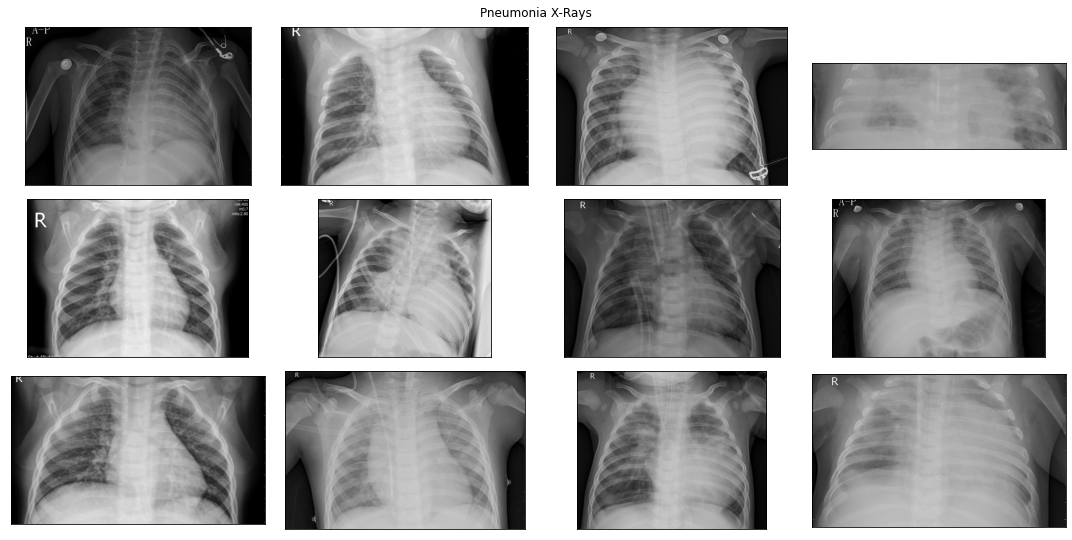

In [11]:
fig = plt.figure(figsize=(15, 10))
npics= 12

count = 1
train_im_p_selected = random.sample(train_im_p, 12)
for i, img in enumerate(train_im_p_selected):
    sample = os.path.join(train_path +labels[1]+'/', img) 
    sample_img = Image.open(sample)   
    ax = fig.add_subplot(int(npics/3), 4, count, xticks=[],yticks=[])   
    plt.imshow(sample_img, cmap='gray')
    count +=1
fig.suptitle('Pneumonia X-Rays')
plt.tight_layout()
plt.show()

### Pneumonia from X-rays

After reading some online resources like [this one](https://www.wikidoc.org/index.php/Pneumonia_chest_x_ray), I see that general way to find Pneumonia is to search for opacity in chest x-rays. From the pics above, the images in general look opaque compared to normal x-rays. But it is also important to remember that, chest x-rays may not tell the whole story all the time and sometimes the visual result can be misleading.  

### Standardization

We will adjust our image data such that the new mean of the data will be zero, and the standard deviation of the data will be 1.

In other words, the generator will replace each pixel value in the image with a new value calculated by subtracting the mean and dividing by the standard deviation. $\frac{x_i−\mu}{\sigma}$

Check the effect.... 

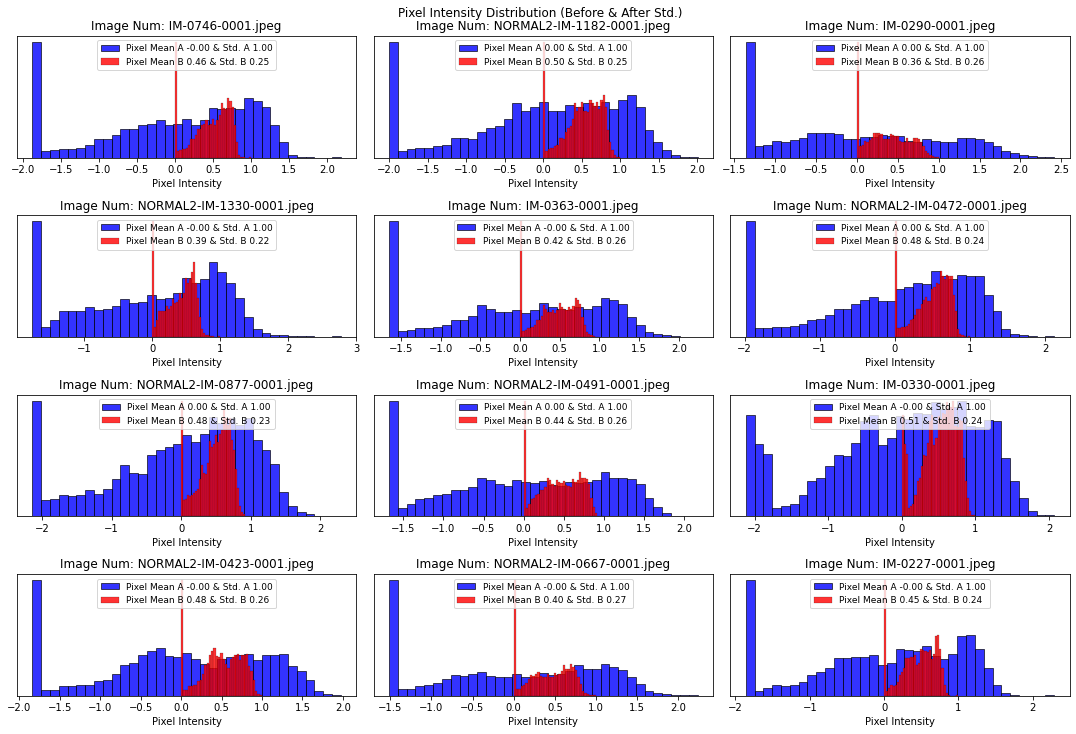

In [12]:
fig = plt.figure(figsize=(15, 15))
count=1
for i, img in enumerate(train_im_n_selected):
    sample_one = os.path.join(train_path +labels[0]+'/', img)
    sample_img = Image.open(sample_one)   
    sample_img = np.array(sample_img)
    sample_img = sample_img/255.0
    sample_img_mean = np.mean(sample_img)
    sample_img_std = np.std(sample_img)
    new_sample_img = (sample_img - sample_img_mean)/sample_img_std
    ax = fig.add_subplot(int(npics/2) , 3, count, yticks=[])
    sns.histplot(new_sample_img.ravel(), 
             label=f'Pixel Mean A {np.mean(new_sample_img):.2f} & Std. A {np.std(new_sample_img):.2f}', kde=False, color='blue', bins=35, alpha=0.8)
    sns.histplot(sample_img.ravel(), 
             label=f'Pixel Mean B {np.mean(sample_img):.2f} & Std. B {np.std(sample_img):.2f}', kde=False, color='red', bins=35, alpha=0.8)
    plt.legend(loc='upper center', fontsize=9)
    plt.title('Image Num: %s'% (img))
    plt.xlabel('Pixel Intensity')
    plt.ylabel('# Pixels in Image')
    count +=1
fig.suptitle('Pixel Intensity Distribution (Before & After Std.)')
plt.tight_layout()
plt.show()

In [13]:
#### define a function that will be added as lambda layer later
def standardize_layer(tensor):
    tensor_mean = tf.math.reduce_mean(tensor)
    tensor_std = tf.math.reduce_std(tensor)
    new_tensor = (tensor-tensor_mean)/tensor_std
    return new_tensor

### ImageDataGenerator Part 

This part we don't add any augmentation. **Our idea is to use the GPU for augmentation.** 

1. Define augmentation layers as sequential. 

2. Target_size = (300, 300) # image size suitable for InceptionResNetV2

3. Input_shape = (300, 300, 1)

4. batch_size = 64 


In [14]:
target_size = (300, 300)

input_shape = (300, 300, 1)

batch_size = 64


print("Training Dataset.....")
train_dir = tf.keras.preprocessing.image_dataset_from_directory('../input/chest-xray-pneumonia/chest_xray/train/', 
                                                                image_size=target_size, 
                                                                batch_size=batch_size,
                                                                shuffle=True,
                                                                color_mode='grayscale',
                                                                label_mode='binary')



print("Val Dataset....")
val_dir = tf.keras.preprocessing.image_dataset_from_directory('../input/chest-xray-pneumonia/chest_xray/val/', 
                                                              image_size=target_size, 
                                                              batch_size=batch_size,
                                                              color_mode='grayscale',
                                                              label_mode='binary')

print("Test Datast...")
test_dir = tf.keras.preprocessing.image_dataset_from_directory('../input/chest-xray-pneumonia/chest_xray/test/', 
                                                               image_size=target_size, 
                                                               batch_size=batch_size, 
                                                               color_mode='grayscale',
                                                               label_mode='binary')

Training Dataset.....
Found 5216 files belonging to 2 classes.
Val Dataset....
Found 16 files belonging to 2 classes.
Test Datast...
Found 624 files belonging to 2 classes.


#### Check the Number of Elements in Dataset (Train + Valid)

In [15]:
num_elements = tf.data.experimental.cardinality(train_dir).numpy()
print (num_elements)
num_elements_val = tf.data.experimental.cardinality(val_dir).numpy()
print (num_elements_val)

82
1


### Get the Class Names

In [16]:
class_names = train_dir.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


### Merge Train and Valid Dataset and then Split

This is where we deal with low number of validation images by merging train and validation dataset and then split. 

In [17]:
new_train_ds = train_dir.concatenate(val_dir)

print (new_train_ds, train_dir)

train_size = int(0.8 * 83) # 83 is the elements in dataset (train + valid)
val_size = int(0.2 * 83)
    
train_ds = new_train_ds.take(train_size)
val_ds = new_train_ds.skip(train_size).take(val_size)


#### check the dataset size back again 
num_elements_train = tf.data.experimental.cardinality(train_ds).numpy()
print (num_elements_train)
num_elements_val_ds = tf.data.experimental.cardinality(val_ds).numpy()
print (num_elements_val_ds)

<ConcatenateDataset shapes: ((None, 300, 300, 1), (None, 1)), types: (tf.float32, tf.float32)> <BatchDataset shapes: ((None, 300, 300, 1), (None, 1)), types: (tf.float32, tf.float32)>
66
16


### Define the Augmentation as Sequential 


Also plot the augmented images for an example training image

(64, 300, 300, 1) <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 1)


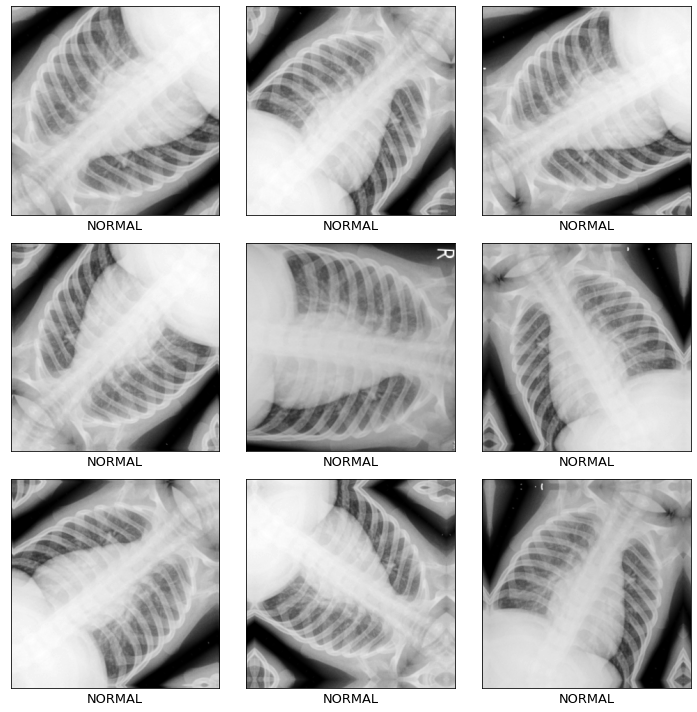

(64, 300, 300, 1) (300, 300, 1)


In [18]:
from tensorflow.keras import layers

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip(),
  layers.experimental.preprocessing.RandomRotation(10), 
  layers.experimental.preprocessing.RandomZoom(0.1)
])


### let's try something fancy 
from itertools import islice, count

train_iter_35im, train_iter_35label = next(islice(train_ds, 35, None)) # access the 35th element (just a random check) from the iterator



print (train_iter_35im.shape, type(train_iter_35im))
print (train_iter_35label.shape)

# train_iter_5im = tf.expand_dims(train_iter_5im, 0)
train_iter_35label = train_iter_35label.numpy()


plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    aug_img = data_augmentation(train_iter_35im)
    plt.imshow(aug_img[0], cmap='gray')
    plt.xlabel(class_names[np.argmax(train_iter_35label)], fontsize=13)
plt.tight_layout()    
plt.show()

print (aug_img.shape, aug_img[0].shape)

In [19]:
autotune = tf.data.AUTOTUNE ### most important function for speed up training


train_data_batches = train_ds.cache().prefetch(buffer_size=autotune)
valid_data_batches = val_ds.cache().prefetch(buffer_size=autotune)
test_data_batches = test_dir.cache().prefetch(buffer_size=autotune)

In [20]:
#### check the numbers again
print (train_data_batches, valid_data_batches)

num_elements_train_data_batches = tf.data.experimental.cardinality(train_data_batches).numpy()
print (num_elements_train_data_batches)

<PrefetchDataset shapes: ((None, 300, 300, 1), (None, 1)), types: (tf.float32, tf.float32)> <PrefetchDataset shapes: ((None, 300, 300, 1), (None, 1)), types: (tf.float32, tf.float32)>
66


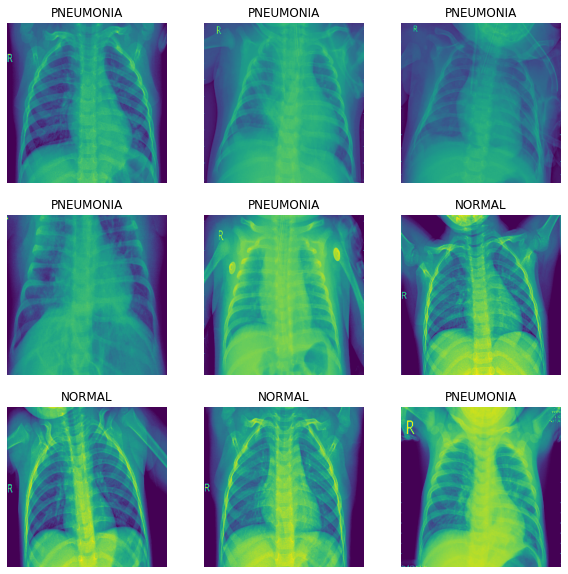

In [21]:
### check if the data batches work properly or not 

plt.figure(figsize=(10, 10))
for images, labels in train_data_batches.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])
        plt.axis("off")  

### Build Model as Sequential 

Add the augmentation layer, pre-processing layers and custom lambda layer. 

We will use pre-trained InceptionResNetV2 with imagenet 

In [22]:
## This cell was used to compile the baseline model
### Cosine Decay was tested

class customCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    self.epoch = epoch + 1
    if self.epoch % 2 == 0:
      print (
          'epoch num {}, train loss: {}, validation loss: {}'.format(epoch, logs['loss'], logs['val_loss']))

reduce_lr = ReduceLROnPlateau(monitor='val_loss',  factor=0.2, patience=3, min_lr=1e-8, verbose=1)



# mcp_save = ModelCheckpoint(filepath="best_model_weights.h5",
#                            save_best_only=True, save_weights_only=True, monitor='val_loss')



## added after saving the best model  via val loss gives worse performance than the final step of the model 

mcp_save = ModelCheckpoint(filepath="best_model_weights.h5",
                           save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')



##restore best weights added after 2nd training
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)


### added after 2nd training 

METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

## Inference from 1st training 


**1. We added train and validation dir files and then create a split (15%) to have bit more validaton files to evaluate the performance.**

## Inference after 3rd Training 

**2. Use weighted binary cross-entropy loss to deal with high number of false positives. Influenced from [AI for Medical Diagnosis](https://www.coursera.org/learn/ai-for-medical-diagnosis/home/welcome) course**. 
The idea behind this is that since we have lot more x-ray images with Pneumonia the model weights them heavy for wrong classification. So we shift this bias and try to force the model to weigh normal and pneumonia images as same.  

To quote from the course---

> We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

> $$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

> Using this formulation, we can see that if there is a large imbalance with fewer negative training images (normal), for example, then the loss will be dominated by the negative class (normal).


### Weighted Cross-Entropy (Binary)

In [23]:
freq_neg = tot_normal_train/(tot_normal_train + tot_pneumonia_train)
freq_pos = tot_pneumonia_train/(tot_normal_train + tot_pneumonia_train)

pos_weights = np.array([freq_neg])
neg_weights = np.array([freq_pos])

print ('check positive weight: ', pos_weights, len(pos_weights))
print ('check negative weight: ', neg_weights)


def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)): # we have only 1 class 
            # for each class, add average weighted loss for that class 
            loss += - (K.mean((pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon)) + 
                              (neg_weights[i] * (1-y_true[:, i]) * K.log(1-y_pred[:, i] + epsilon)) ) )
        return loss
    return weighted_loss

check positive weight:  [0.25783639] 1
check negative weight:  [0.74216361]


In [24]:
input_shape = (300, 300, 3)

inception_resnet_v2 = InceptionResNetV2(
    include_top=False,
    weights="../input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5",
    input_shape=input_shape)

def build_model():
    inputs = Input((300, 300, 1))
    
    x = preprocess_input(inputs) # necessary as per keras documentation 
    x = layers.Lambda(rescale_layer)(x) # rescale incoming images
    x = layers.Lambda(standardize_layer)(x) # standardize incoming images
    x = layers.Lambda(data_augmentation)(x) # data augmentation layers
    x = Conv2D(3, (3,3), padding='same')(x) 
    # this is to fool the network that instead of rgb image we passed grayscale image but still have shape 3 at last axis (none, x, x, 3). 
    
    
    
    ###### InceptionResNetV2 + Some Top Layers
    x = BatchNormalization()(x)
    x = inception_resnet_v2(x)

    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (1, 1), activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dropout(0.75)(x)

    x = Dense(256, activation=LeakyReLU())(x)
    x = Dropout(0.80)(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs, outputs)
    
#     model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
#                   loss="binary_crossentropy", 
#                   metrics=METRICS)
# added weighted cross entropy loss for the loss instead of 
# "binary_crossentropy"

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss=get_weighted_loss(pos_weights, neg_weights), 
                 metrics=METRICS)



    
    return model

In [25]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 1)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 300, 300, 1)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 300, 300, 1)       0         
_________________________________________________________________
lambda (Lambda)              (None, 300, 300, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 300, 300, 1)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 300, 300, 1)       0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 300, 300, 3)       30    

In [26]:
# #### check difference between numpy mean and tensorflow reduce mean 
# same essentially 
# check = np.random.random((2, 2, 3))
# print ('original arr: ', check)
# print ('numpy mean: ', np.mean(check))


# Mean_check = tf.math.reduce_mean(check)
# tf.print('tensorflow reduce mean:', Mean_check)


### Prepare to Train the Network 

In [27]:
start_time = time.time()
history = model.fit(train_data_batches, 
                    epochs=100, 
                    validation_data=valid_data_batches,
                    callbacks=[mcp_save, es, reduce_lr])

end_time = time.time()

Epoch 1/100
66/66 [==============================] - 136s 2s/step - loss: 0.2066 - accuracy: 0.7384 - precision: 0.9120 - recall: 0.7164 - prc: 0.9226 - val_loss: 3.0176 - val_accuracy: 0.7450 - val_precision: 0.7450 - val_recall: 1.0000 - val_prc: 0.7450
Epoch 2/100
66/66 [==============================] - 74s 1s/step - loss: 0.0697 - accuracy: 0.9417 - precision: 0.9774 - recall: 0.9437 - prc: 0.9907 - val_loss: 0.2195 - val_accuracy: 0.8548 - val_precision: 0.8723 - val_recall: 0.9432 - val_prc: 0.9760
Epoch 3/100
66/66 [==============================] - 74s 1s/step - loss: 0.0561 - accuracy: 0.9453 - precision: 0.9798 - recall: 0.9464 - prc: 0.9950 - val_loss: 0.0302 - val_accuracy: 0.9808 - val_precision: 0.9878 - val_recall: 0.9865 - val_prc: 0.9987
Epoch 4/100
66/66 [==============================] - 74s 1s/step - loss: 0.0419 - accuracy: 0.9652 - precision: 0.9852 - recall: 0.9679 - prc: 0.9968 - val_loss: 0.1149 - val_accuracy: 0.9244 - val_precision: 0.9940 - val_recall: 0.90

In [28]:
print ('total time taken: in Minutes', (end_time-start_time)/60.)

total time taken: in Minutes 24.58229122956594


#### Training and Validation (Loss & Accuracy)

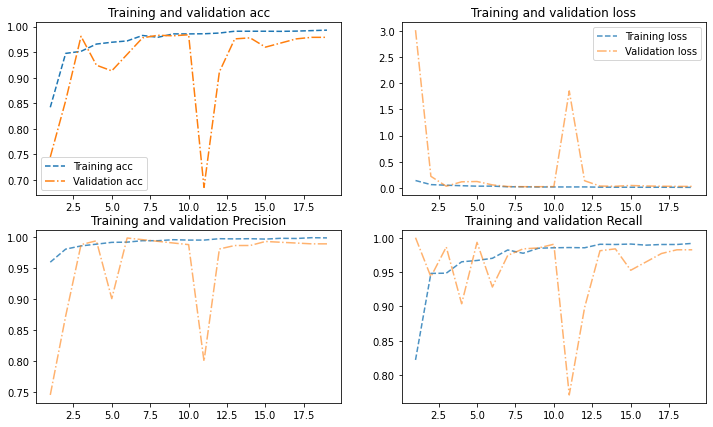

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']


epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(12, 7))
fig.add_subplot(221)

plt.plot(epochs, acc, linestyle='--', label = "Training acc")
plt.plot(epochs, val_acc, linestyle='-.', label = "Validation acc")
plt.title("Training and validation acc")
plt.legend()

fig.add_subplot(222)
plt.plot(epochs, loss, linestyle='--', label = "Training loss", alpha=0.8)
plt.plot(epochs, val_loss, linestyle='-.', label = "Validation loss", alpha=0.6)
plt.title("Training and validation loss")
plt.legend()

fig.add_subplot(223)
plt.plot(epochs, precision, linestyle='--', label = "Training Precision", alpha=0.8)
plt.plot(epochs, val_precision, linestyle='-.', label = "Validation Precision", alpha=0.6)
plt.title("Training and validation Precision")

fig.add_subplot(224)
plt.plot(epochs, recall, linestyle='--', label = "Training Recall", alpha=0.8)
plt.plot(epochs, val_recall, linestyle='-.', label = "Validation Recall", alpha=0.6)
plt.title("Training and validation Recall")

plt.show()

In [30]:
model.evaluate(test_data_batches)

10/10 [==============================] - 7s 404ms/step - loss: 0.2316 - accuracy: 0.8622 - precision: 0.8207 - recall: 0.9974 - prc: 0.9808


[0.23164744675159454,
 0.8621794581413269,
 0.8206751346588135,
 0.9974358677864075,
 0.980838418006897]

In [31]:
#### check if the saved weights work fine or not 

model.load_weights("best_model_weights.h5")
model.evaluate(test_data_batches)

10/10 [==============================] - 3s 305ms/step - loss: 0.2316 - accuracy: 0.8622 - precision: 0.8207 - recall: 0.9974 - prc: 0.9808


[0.23164744675159454,
 0.8621794581413269,
 0.8206751346588135,
 0.9974358677864075,
 0.980838418006897]

## Inference from 2nd Training 

**1. Saving the best model via lowest ```val_loss``` isn't the best strategy.**  

**May need to define some other metrics like precision and recall.** 

## Inference from 3rd Training 

**2. Added necessary metrics like precision, recall but saving via ```val_prc``` still gives worse performance than the original model.** 

**Added ```restore_best_weights=True``` in EarlyStopping.**

**Added ```val_loss``` as the saving strategy in the Checkpoint, after step 2**

### Prepare for Prediction and Confusion Matrix

In [32]:
y_pred = model.predict(test_data_batches)
print ('check y_pred: ', y_pred[0:10])

check y_pred:  [[0.99318826]
 [0.9664159 ]
 [0.6265392 ]
 [0.9971723 ]
 [0.6311654 ]
 [0.00167112]
 [0.79972225]
 [0.982272  ]
 [0.35845193]
 [0.27843538]]


In [33]:
#### set a different threshold 

y_pred_th = (y_pred > 0.75).astype(np.float32)
#predicted_categories_th = tf.argmax(y_pred_th, axis=1)
#print ('check predicted catagories: ', predicted_categories_th[0:10])
print (y_pred_th[0:10])

[[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]]


In [34]:
true_categories = tf.concat([y for x, y in test_data_batches], axis=0)
print ('check true catagories: ', true_categories[0:10])

check true catagories:  tf.Tensor(
[[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]], shape=(10, 1), dtype=float32)


In [35]:
from sklearn.metrics import confusion_matrix
#print(confusion_matrix(test.classes, pred > 0.7))
#pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))
cm = confusion_matrix(y_pred_th, true_categories)

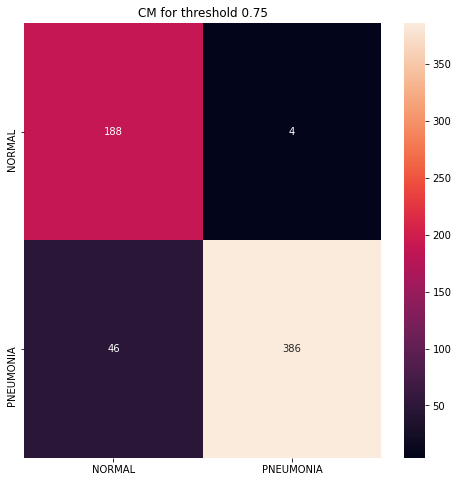

In [36]:
plt.figure(figsize=(8,8))
plt.title('CM for threshold 0.75')
sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_names[i] for i in range(len(class_names))], 
                      yticklabels = [class_names[i] for i in range(len(class_names))], fmt="d")
fig = sns_hmp.get_figure()

### Plot the ROC Curve 

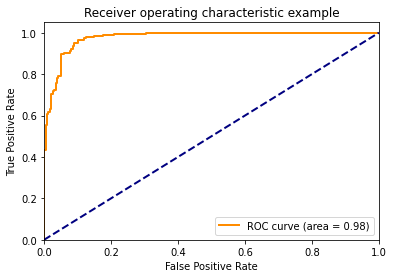

In [37]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(true_categories, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Inference from 3rd Training 

**1. There are a lot of false positive still. To reduce that I will try a weighted binary cross-entropy loss.** 

The implementation is influenced from [AI for Medical Diagnosis course](https://www.coursera.org/learn/ai-for-medical-diagnosis/home/welcome). 
Highly recommend that course as it deals with the chest x-ray dataset too. 


## Check Test Set Predictions and Images

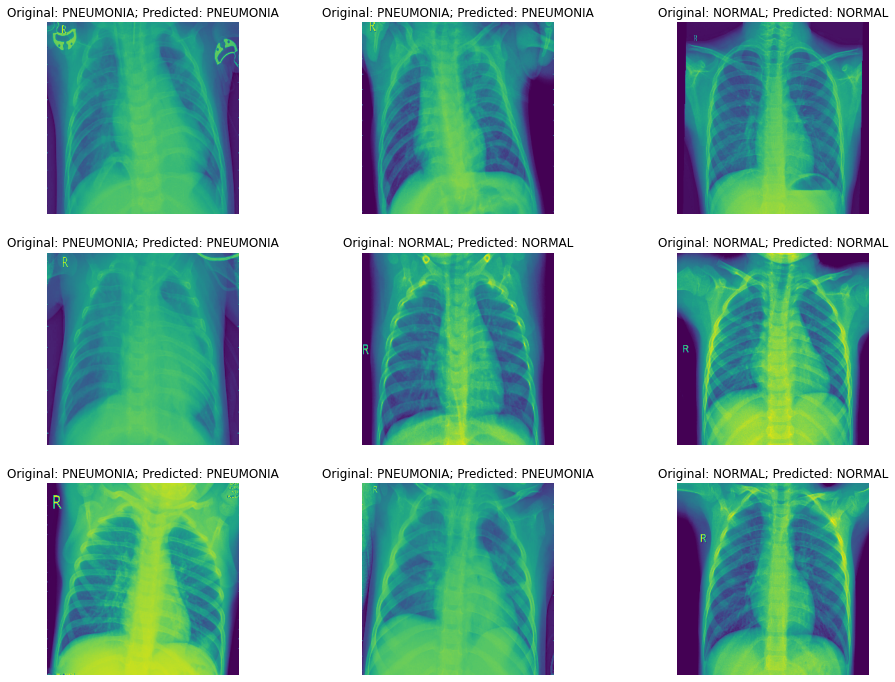

In [38]:
plt.figure(figsize=(16, 12))
for images, labels in test_data_batches.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        
        y_pred_batch = model.predict(tf.expand_dims(images[i], axis=0, ))
        y_pred_75th = (y_pred_batch > 0.75).astype(np.uint8)
        original_label = class_names[labels[i].numpy().astype("uint8")[0]]
        predicted_label = class_names[y_pred_75th[0].astype("uint8")[0]]
        plt.title(f'Original: {original_label}; Predicted: {predicted_label}')
        plt.axis("off")            